# CNN from scratch

Train and validate the CNN model from scratch using Tensorflow

In [1]:
# Set tensorflow backend to use only required GPU memory
import tensorflow as tf

def get_session_growth():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    return sess

sess = get_session_growth()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
HEIGHT = 49
WIDTH = 37

In [6]:
TRAIN_DIR = "pklot_dataset/cnn_dataset/train/"
BATCH_SIZE = 32

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='binary')

Found 5000 images belonging to 2 classes.


In [7]:
VALID_DIR = "pklot_dataset/cnn_dataset/valid/"
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
validation_generator = valid_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 500 images belonging to 2 classes.


### Train model from scratch

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation

In [20]:
nb_train_samples = 5000
batch_size = 32
nb_validation_samples = 500
epochs = 10

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(HEIGHT, WIDTH, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [22]:
# fine-tune the model
scratch_hist = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/10
156/156 [==============================] - 7s 42ms/step - loss: 1.0217 - acc: 0.7208 - val_loss: 0.6984 - val_acc: 0.5312
Epoch 2/10
156/156 [==============================] - 7s 43ms/step - loss: 0.3480 - acc: 0.8448 - val_loss: 0.8095 - val_acc: 0.5312
Epoch 3/10
156/156 [==============================] - 6s 41ms/step - loss: 0.2505 - acc: 0.9044 - val_loss: 1.1335 - val_acc: 0.5312
Epoch 4/10
156/156 [==============================] - 6s 41ms/step - loss: 0.2289 - acc: 0.9149 - val_loss: 1.6870 - val_acc: 0.5312
Epoch 5/10
156/156 [==============================] - 7s 42ms/step - loss: 0.2079 - acc: 0.9259 - val_loss: 2.2469 - val_acc: 0.5312
Epoch 6/10
156/156 [==============================] - 6s 41ms/step - loss: 0.1852 - acc: 0.9279 - val_loss: 3.0732 - val_acc: 0.5312
Epoch 7/10
156/156 [==============================] - 7s 42ms/step - loss: 0.1828 - acc: 0.9345 - val_loss: 4.3583 - val_acc: 0.5312
Epoch 8/10
156/156 [==============================] - 6s 41ms/step - 

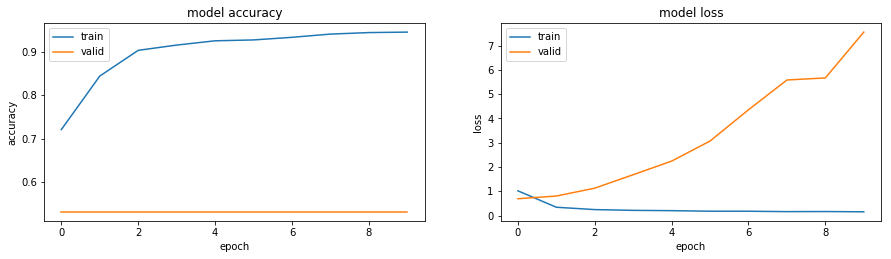

In [23]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(scratch_hist.history['acc'])  
plt.plot(scratch_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(scratch_hist.history['loss'])  
plt.plot(scratch_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

## Model prediction on validation dataset

In [24]:
from glob import glob
import numpy as np
from utils import load_image
import cv2

In [25]:
occupied_dir = "pklot_dataset/cnn_dataset/valid/Occupied/*.jpg"
empty_dir = "pklot_dataset/cnn_dataset/valid/Empty/*.jpg"

valid_images = glob(occupied_dir) + glob(empty_dir)

In [33]:
valid_sample_size = 250 # To run  on complete valid dataset. Please set this to 50000 (value greater than number of valid images)
valid_images = list(valid_images)
np.random.shuffle(valid_images)
valid_images = valid_images[:valid_sample_size]

In [28]:
ground_truth = []
prediction = []
for img in valid_images:
    label = img.split("/")[-2]
    if label == "Occupied":
        ground_truth.append(1)
    else:
        ground_truth.append(0)
    image = load_image(img)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image_x = np.expand_dims(image, axis=0)
    image_x = preprocess_input(image_x)
    pred = model.predict(image_x)
    pred = np.squeeze(pred)
    if pred > 0.98:
        prediction.append(1)
    else:
        prediction.append(0)
    

### Validate the model

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
# Show the classification metrics
print(classification_report(ground_truth, prediction, target_names=['Empty', 'Occupied']))

             precision    recall  f1-score   support

      Empty       0.84      1.00      0.91       150
   Occupied       1.00      0.71      0.83       100

avg / total       0.90      0.88      0.88       250



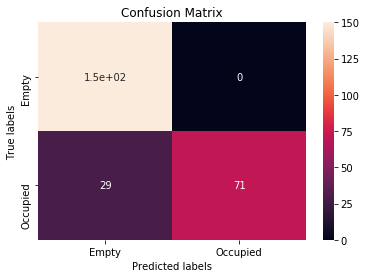

In [31]:
# confusion matrix
cm = confusion_matrix(ground_truth, prediction)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Empty', 'Occupied']); 
ax.yaxis.set_ticklabels(['Empty', 'Occupied']);

In [32]:
print("Confusion matrix")
print(cm)

Confusion matrix
[[150   0]
 [ 29  71]]
